# Case Study 1 - Evaluate impact from environmental events/pressures
## Description 
I want to aggregate observations of _Caladenia_ orchids in the ACT so I can analyse the relationship between records and the protection status and vegetation cover of the locations of each species.
## Case Breakdown 
- **Actors:** Plant researcher
- **Goals:** Compare the abundance of wild orchid flowers based on habitat type and protection status
- **Scope:** Regional, 30-year aggregated
## Generalised case
I want to combine a suite of spatial variables at different scales across multiple sites so I can analyse the factors correlated with a variable of interest.
## Comparable cases
- As a grains researcher, I want to aggregate spatial data for frost and other extreme weather events associated with chickpeas and wheat grown at Merredin and other sites in Western Australia, so I can analyse the effects of such events on different varieties at different stages and advise growers on the best choices. 
- I want to aggregate iMapPests data for the same pest across multiple sites and locations so I can analyse the relationship between population levels and environmental context at the time and over the previous month, including weather (temperature, rainfall, humidity - all xyt), lunar phase (t) and greenness (xyt - see https://portal.tern.org.au/metadata/TERN/8542d90e-6e20-4ad8-b30d-0a171b61d3f5).
## Stakeholders 
- **Name:** Martin Westgate (Atlas of Living Australia)
- **Contact:** martin.westgate@csiro.au


## Data Sources
The implementation uses the following data sources (all in the source_data subfolder):
- **vegetation_cover_northern.tif** - GA Landsat Vegetation Cover GeoTIFF at 25m2 for the northern two thirds of the ACT and adjacent NSW in 2020: https://explorer.dea.ga.gov.au/products/ga_ls_landcover_class_cyear_2/datasets/67bb9d38-00c7-46ba-a5e9-b892d9f9ad42 (values defined here: https://knowledge.dea.ga.gov.au/data/product/dea-land-cover-landsat/?tab=details)
- **vegetation_cover_southern.tif** - GA Landsat Vegetation Cover GeoTIFF at 25m2 for the southern third of the ACT and adjacent NSW in 2020: https://explorer.dea.ga.gov.au/products/ga_ls_landcover_class_cyear_2/datasets/464fd7e2-0554-4095-80e1-42e00f087831
- **boundary_act.geojson** - 2023 boundary for the Australian Capital Territory from the ACT Government in GeoJSON format: https://actmapi-actgov.opendata.arcgis.com/datasets/ACTGOV::actgov-border/explore
- **capad_act.geojson** - Protected Area data for the Australian Capital Territory in 2022 from the CAPAD dataset in GeoJSON format: https://fed.dcceew.gov.au/datasets/ec356a872d8048459fe78fc80213dc70_0/explore?filters=eyJTVEFURSI6WyJBQ1QiXX0%3D&location=-35.437128%2C149.203518%2C11.00
- **caladenia_act.csv** - Distribution records for orchids in the genus _Caladenia_ between 1990 and present from the ALA in CSV format: https://doi.org/10.26197/ala.1e501311-7077-403b-a743-59e096068fa0

## Imports

In [375]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import shutil
import pystac
import pystac_client
import subprocess
import json

from stac_generator import StacGeneratorFactory
from stac_generator.core.base.generator import StacSerialiser
from stac_generator.core.base.schema import StacCollectionConfig, ColumnInfo
from stac_generator.core.raster.schema import RasterConfig, BandInfo
from stac_generator.core.vector.schema import VectorConfig
from stac_generator.core.point.schema import PointConfig

from mccn.client import MCCN

## Data Paths

In [376]:
# Paths to current folder and scratch folder for working files
current_folder = os.getcwd()
scratch_folder = os.path.join(current_folder, "scratch")

if not os.path.exists(scratch_folder):
    os.makedirs(scratch_folder)

# Paths to source files
cover_n_source = os.path.join(current_folder, "source_data/vegetation_cover_northern.tif")
cover_s_source = os.path.join(current_folder, "source_data/vegetation_cover_southern.tif")
caladenia_source = os.path.join(current_folder, "source_data/caladenia_act.csv")
boundary_source = os.path.join(current_folder, "source_data/boundary_act.geojson")
capad_source = os.path.join(current_folder, "source_data/capad_act.geojson")

# Paths for generating configuration files for STAC records
cover_n_configuration_filename = os.path.join(scratch_folder, "cover_n_config.json")
cover_s_configuration_filename = os.path.join(scratch_folder, "cover_s_config.json")
boundary_configuration_filename = os.path.join(scratch_folder, "boundary_config.json")
capad_configuration_filename = os.path.join(scratch_folder, "capad_config.json")


## Prepare orchid datasets

All orchid species are included in a single file with many columns. Only the scientific name and coordinates are relevant for this case study. Different species may have occurred at the same coordinates. Importing the complete file as a single xarray DataArray would leave only one scientific name for each point. So we split the file into one for each species with 1o or more records.

Records with incomplete coordinates or uncertainty greater than 1000 m are excluded. For a real analysis, greater precision would be required.

In [377]:

# Read caladenia_source, discard all columns but the scientific name and coordinates, and drop all records without complete coordinates or low precision.
caladenia = pd.read_csv(caladenia_source, encoding="UTF8")[["scientificName", "decimalLatitude", "decimalLongitude", "coordinateUncertaintyInMeters"]]
caladenia = caladenia[~((caladenia["decimalLatitude"].isna()) | (caladenia["decimalLatitude"].isna()) | (caladenia["coordinateUncertaintyInMeters"] > 1000))]

# Generate separate CSV files for each species with 10 or more observations (filenames held in species_files)
species = caladenia.rename(columns= {'decimalLatitude':'count'}).groupby("scientificName")["count"].count().reset_index()
species = species[species["count"] >= 10]["scientificName"].tolist()

# Generate space-free keys for each species and save data for each species to a corresponding filename.
species_keys = [s.replace(' ', '_') for s in species]
species_files = {s: os.path.join(scratch_folder, f"{s}.csv") for s in species_keys}

for s, sk in zip(species, species_keys):
    sf = species_files[sk]
    caladenia_subset = caladenia.loc[caladenia["scientificName"] == s].copy()
    caladenia_subset[sk] = 1.0
    caladenia_subset.to_csv(sf, encoding="utf8")

## Generate configuration files for STAC collection

In [378]:
# Configuration for collection as a whole.
collection_config = StacCollectionConfig(
    id="CaladeniaStudy",
    title="Datasets for Caladenia case study",
    description="STAC records for accessing datasets to explore as part of the MCCN case study 1 relating to distribution of orchids in the genus Caladenia in the northern ACT",
    license="CC-BY-4.0",
)

# List of configurations for individual data layers.
configurations = [
    
    VectorConfig(
        id="ACT_Boundary",
        location=boundary_source,
        collection_date="2024-12-31",
        collection_time="00:00:00"
    ),

    VectorConfig(
        id="ACT_CAPAD",
        location=capad_source,
        collection_date="2024-12-31",
        collection_time="00:00:00",
        column_info=[
            ColumnInfo(name="PA_ID"),
        ]
    ),

    RasterConfig(
        id="Vegetation_Cover_Northern",
        location=cover_n_source,
        collection_date="2024-12-31",
        collection_time="00:00:00",
        band_info=[
            BandInfo(name="vegetation_north", description="Vegetation cover level")
        ]
    ),

    RasterConfig(
        id="Vegetation_Cover_Southern",
        location=cover_s_source,
        collection_date="2024-12-31",
        collection_time="00:00:00",
        band_info=[
            BandInfo(name="vegetation_south", description="Vegetation cover level")
        ]
    ),
] + [
    PointConfig(
        id=sk,
        location=species_files[sk],
        collection_date="2024-12-31",
        collection_time="00:00:00",
        X="decimalLongitude",
        Y="decimalLatitude",
        column_info=[
            ColumnInfo(name=sk, description=f"{s} reported as present"),
        ]
    ) for sk in species_keys
]

# Build the generator using the configurations.
generator = StacGeneratorFactory.get_stac_generator(
    source_configs=configurations,
    collection_config=collection_config
)

# Serialise the STAC collection. This will generate the collection JSON file and item JSON files for each layer.
serialiser = StacSerialiser(generator, scratch_folder)
serialiser()

INFO:stac_generator.core.base.generator:successfully save collection to /home/dhobern/projects/mccn-case-studies/Case 1/scratch


## DataCube Load
Load data for all STAC items for the vegetation cover, ACT boundary, CAPAD shapes and orchid species records into a new data cube, using the boundary, CRS and shape from the vegetation cover layer. Use a 400 * 400 canvas and fill areas without values with 0.

In [379]:
# Using the locally generated collection
endpoint = os.path.join(scratch_folder, "collection.json")
client = MCCN(endpoint, "CaladeniaStudy", shape=(400,400), point_nodata=0)
ds = client.load()

# The xarray includes a time dimension with a single position. Removing this dimension simplifies the indexing in all later steps.
ds = ds.isel(time=0)

# Variable containing all ones for simplified masking
ds["all_ones"] = 1

# Display DataSet.
ds

<xarray.Dataset> Size: 23MB
Dimensions:                (y: 400, x: 400)
Coordinates:
    time                   datetime64[ns] 8B 2024-12-30T13:55:00
    spatial_ref            int32 4B 4326
  * y                      (y) float64 3kB -34.71 -34.71 -34.72 ... -36.6 -36.61
  * x                      (x) float64 3kB 148.5 148.5 148.5 ... 150.8 150.8
Data variables: (12/20)
    Caladenia_alpina       (y, x) float64 1MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Caladenia_atrovespa    (y, x) float64 1MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Caladenia_carnea       (y, x) float64 1MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Caladenia_catenata     (y, x) float64 1MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Caladenia_congesta     (y, x) float64 1MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Caladenia_cucullata    (y, x) float64 1MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                     ...
    Caladenia_ustulata     (y, x) float64 1MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    PA_ID                  (y, x) int64 1MB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    ACT_Boundary           (y, x) int64 1MB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    vegetation_north       (y, x) float32 640kB 255.0 255.0 255.0 ... 0.0 0.0
    vegetation_south       (y, x) float32 640kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    all_ones               int64 8B 1
Attributes:
    PA_ID:    {1: 'ACT_34', 2: 'ACT_01', 3: 'ACT_03', 4: 'ACT_39', 5: 'ACT_14...

## Organise Vegetation Cover
The two tiles for vegetation cover together completely overlay the ACT (excluding Jervis Bay). The tiles use the following pixel values:

- 0: Not applicable (such as in bare areas)
- 10: Closed (>65%)
- 12: Open (40 to 65%)
- 13: Open (15 to 40%)
- 15: Sparse (4 to 15%)
- 16: Scattered (1 to 4%)

Since 0 is a meaningful value in these data, the tiles specify use of 255 as the fill value where there is no data. To merge these tiles into a single variable, we will first replace these 255 pixels with 0. This will not impact subsequent analysis (since usage will be restricted to the ACT area and all 0 values in that area are significant), but it simplifies the combining of the two tiles.

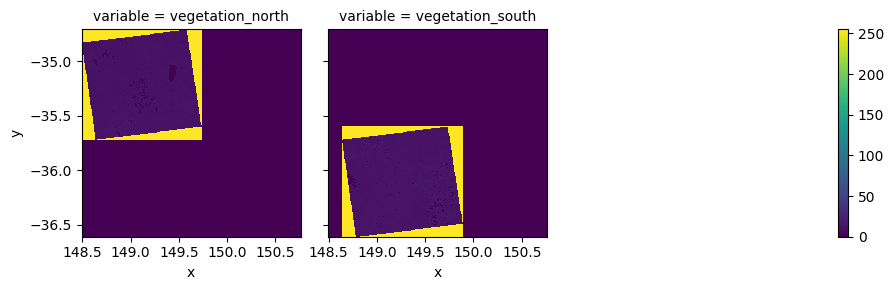

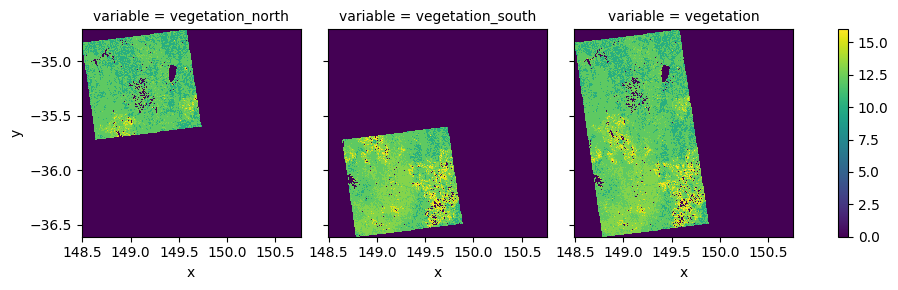

In [ ]:
# Display imported form of vegetation tiles.
ds[["vegetation_north", "vegetation_south"]].to_array().plot(x="x", col="variable", col_wrap=3)

# Clean and merge tiles.
ds["vegetation_north"] = ds.vegetation_north.where(ds.vegetation_north < 255, 0)
ds["vegetation_south"] = ds.vegetation_south.where(ds.vegetation_south < 255, 0)
ds["vegetation"] = ds.vegetation_north.where(ds.vegetation_north > 0, ds.vegetation_south)

# Display clean and merged layers.
ds[["vegetation_north", "vegetation_south", "vegetation"]].to_array().plot(x="x", col="variable", col_wrap=3)

## Organise Protected Areas
The source data includes separate shapes for each ACT protected area. Merge these into a single mask with 1 for protected area pixels and 0 otherwise.

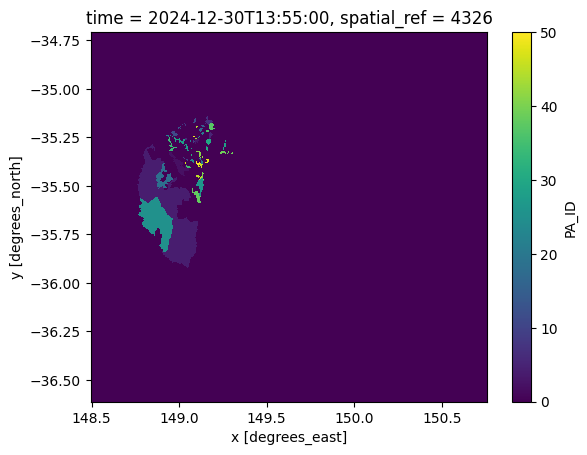

In [381]:
# Display original variable
ds.PA_ID.plot(x="x")

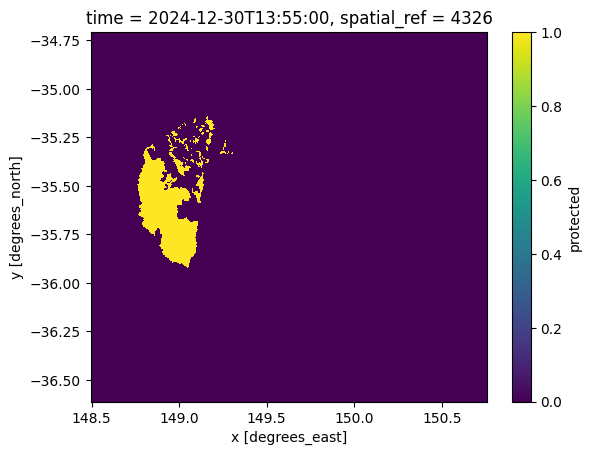

In [382]:

# Unify protected areas into a single mask
ds["protected"] = ds.PA_ID.where(ds.PA_ID == 0, 1)
ds.protected.plot(x="x")


## Organise Species data
Get counts of remaining pixels for each species and drop layers with fewer than 10 records.

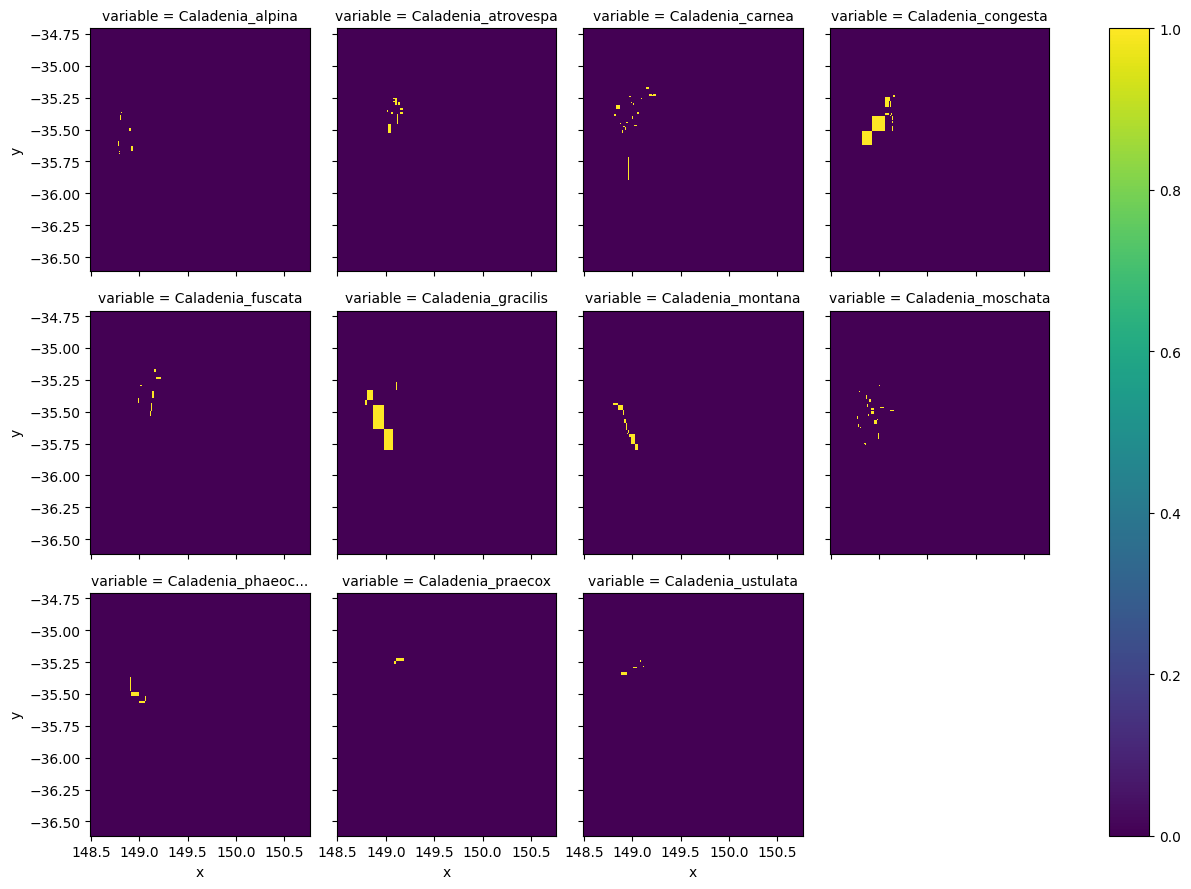

In [383]:
# Collect counts of pixels per species for later use
species_pixels = {}
for s in species_keys:
    species_pixels[s] = ds.ACT_Boundary.where(ds.ACT_Boundary == 0, ds.all_ones.where(ds[s] == 1, 0)).sum().item()

    # Drop species with fewer than 10 records
    if species_pixels[s] < 10:
        species_keys.remove(s)
        ds.drop_vars(s)

# Display grid of remaining species
ds[species_keys] = ds[species_keys].where(ds.ACT_Boundary > 0, 0).astype(int)
ds[species_keys].to_array().plot(x="x", col="variable", col_wrap=4)

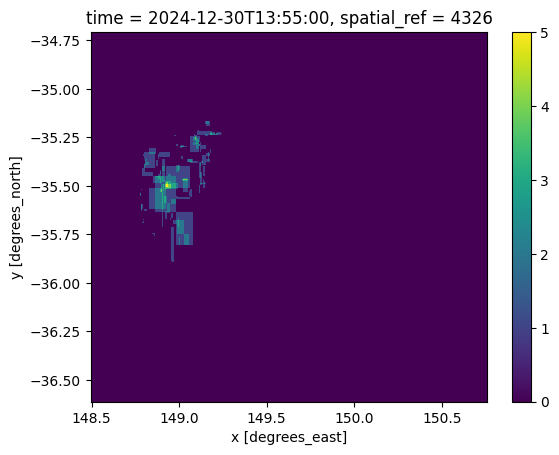

In [384]:
# Show species density per pixel
ds[species_keys].to_array().sum("variable").plot(x="x")

## Calculate Affinities
1. Visualise all layers in a grid
2. Crop all layers to boundary in boundary_source layer
3. Generate and display pivot table showing orchid species as rows, vegetation cover levels for columns, and measures of affinity between the species and cover levels (observed/expected) as values
4. Generate and display pivot table showing orchid species as rows, inclusion and exclusion from CAPAD areas as two columns, and measures of affinity between the species and protection status (observed/expected)  as values

For each species, report percentage of records found in protected areas (included in CAPAD) for 1) vegetation cover level with most records, 2) all vegetation cover levels

In [385]:
# Dictionary of vegetation cover levels - organise keys in a sensible order.
levels = {
    0: "Not applicable (such as in bare areas)",
    10: "Closed (>65 %)",
    12: "Open (40 to 65 %)",
    13: "Open (15 to 40 %)",
    15: "Sparse (4 to 15 %)",
    16: "Scattered (1 to 4 %)",
}

level_keys = sorted(levels.keys())
level_keys[-1] = level_keys.pop(0)

# Dictionary of protected area statuses.
protection = {
    0: "unprotected",
    1: "protected",
}

protection_keys = sorted(protection.keys())

# Pandas dataframes to contain results. 
# The "Total pixels" row and column are to store the number of pixels associated with each row or column. 
# Other cells will contain measures of affinity between a species and a class of pixels (vegetation cover level or protected area status).
vegetation_affinity = pd.DataFrame(index=(["Total pixels"] + species_keys), columns=(["Total pixels"] + [levels[l] for l in level_keys]))
protection_affinity = pd.DataFrame(index=(["Total pixels"] + species_keys), columns=(["Total pixels"] + [protection[p] for p in protection_keys]))

# Count of total number of pixels in study area (i.e. ACT).
study_pixels = ds.ACT_Boundary.sum().item()
vegetation_affinity.loc["Total pixels", ["Total pixels"]] = study_pixels
protection_affinity.loc["Total pixels", ["Total pixels"]] = study_pixels

# Counts of number of pixels associated with each vegetation cover level.
level_pixels = {}
for l in level_keys:
    level_pixels[l] = ds.ACT_Boundary.where(ds.ACT_Boundary == 0, ds.all_ones.where(ds.vegetation == l, 0)).sum().item()
    vegetation_affinity.loc["Total pixels", [levels[l]]] = level_pixels[l]

# Counts of number of pixels associated with each protected area status.
protection_pixels = {}
for p in protection_keys:
    protection_pixels[p] = ds.ACT_Boundary.where(ds.ACT_Boundary == 0, ds.all_ones.where(ds.protected == p, 0)).sum().item()
    protection_affinity.loc["Total pixels", [protection[p]]] = protection_pixels[p]

# Counts of number of pixels in which each species has been recorded
species_pixels = {}
for s in species_keys:
    species_pixels[s] = ds.ACT_Boundary.where(ds.ACT_Boundary == 0, ds.all_ones.where(ds[s] == 1, 0)).sum().item()
    vegetation_affinity.loc[s, ["Total pixels"]] = species_pixels[s]
    protection_affinity.loc[s, ["Total pixels"]] = species_pixels[s]

    # Counts of number of pixels in each vegetation cover level which each species has been recorded and number expected if distribution is random. Affinity is defined as the ratio of these numbers.
    for l in level_keys:
        observed = ds.ACT_Boundary.where(ds.ACT_Boundary == 0, ds[s].where(ds[s] == 0, ds.all_ones.where(ds.vegetation == l, 0))).sum().item()
        expected = (species_pixels[s] * level_pixels[l]) / study_pixels
        vegetation_affinity.loc[s, [levels[l]]] = observed / expected

    # Counts of number of pixels in each protected area status which each species has been recorded and number expected if distribution is random. Affinity is defined as the ratio of these numbers.
    for p in protection_keys:
        observed = ds.ACT_Boundary.where(ds.ACT_Boundary == 0, ds[s].where(ds[s] == 0, ds.all_ones.where(ds.protected == p, 0))).sum().item()
        expected = (species_pixels[s] * protection_pixels[p]) / study_pixels
        protection_affinity.loc[s, [protection[p]]] = observed / expected

## Results For Affinity Between Species And Vegetation Cover
Based on the ALA data, _Caladenia congesta_ recorded show an affinity with more closed locations, while _Caladenia montana_, _Caladenia ustulata_, _Caladenia gracilis_, _Caladenia alpina_ and _Caladenia moschata_ show an affinity with open locations. Some species are intermediate and a couple have coordinates indicating affinity with non-vegetated areas - these seem to be species particularly often recorded in suburban settings by citizen scientists.

In [386]:

# Display vegetation affinity results
vegetation_affinity


,Total pixels,Closed (>65 %),Open (40 to 65 %),Open (15 to 40 %),Sparse (4 to 15 %),Not applicable (such as in bare areas)
Total pixels,8678,709,4559,2173,542,621
Caladenia_alpina,78,0.0,0.805322,1.89438,1.436891,0.179157
Caladenia_atrovespa,246,0.746328,1.168401,0.470785,0.130171,2.783486
Caladenia_carnea,354,0.864391,1.258238,0.73328,0.859351,0.355277
Caladenia_congesta,1206,1.644149,1.09853,0.844409,0.371733,0.71841
Caladenia_fuscata,157,1.013484,1.394274,0.356113,0.101981,1.157102
Caladenia_gracilis,1631,0.285169,0.800609,1.606238,1.619759,0.496938
Caladenia_montana,364,0.033626,0.768716,1.349471,2.771147,0.882987
Caladenia_moschata,190,0.322099,0.981799,1.303161,1.348301,0.441292
Caladenia_phaeoclavia,202,1.03008,1.187324,0.869884,0.713365,0.415076


## Results For Affinity Between Species And Protection Status
Based on the ALA data, several species show a clear affinity with protected areas (particularly the montane species which do not occur closer to the city). However, many species have been recorded more prominently in unprotected areas. As before, this should not be treated as a significant result. It most likely reflects the activities of citizen scientists.

In [387]:

# Display protection affinity results
protection_affinity


,Total pixels,unprotected,protected
Total pixels,8678,3818,4860
Caladenia_alpina,78,0.02914,1.762704
Caladenia_atrovespa,246,1.755506,0.406477
Caladenia_carnea,354,0.751219,1.195442
Caladenia_congesta,1206,1.125151,0.901682
Caladenia_fuscata,157,1.230561,0.818872
Caladenia_gracilis,1631,0.36651,1.497668
Caladenia_montana,364,0.062443,1.736542
Caladenia_moschata,190,0.454584,1.428477
Caladenia_phaeoclavia,202,1.147711,0.883959


## Cleanup
Beware - this will delete all generated files.

In [388]:
# Clean up scratch folder

shutil.rmtree(scratch_folder)